In [1]:
import numpy as np
import datetime

In [2]:
class Hospital:
    #adding an substracting times in pythons datetime
    #package only works for the datetime data type.
    #Therefore a dummy date 01.01.2000 is used, but is
    #of no importance.
    opening_time = datetime.datetime(2000,1,1,9,0)
    closing_time = datetime.datetime(2000,1,1,16,0)
    
    def __init__(self,
                 mean_arrival_time=10,
                 min_wait_time=5,
                 max_wait_time=20,
                 doctors=3):
        self.doc_availibility_t = np.array(doctors*[Hospital.opening_time])
        self.mean_arrival_time = mean_arrival_time
        self.min_wait_time=5
        self.max_wait_time = 20
        self.doctors = 3

        last_patient_arrival = Hospital.opening_time
        self.arrival_times = []
        while True:
            last_patient_arrival += datetime.timedelta(
                minutes=np.random.exponential(scale=mean_arrival_time))
            if last_patient_arrival>Hospital.closing_time:
                break
            self.arrival_times.append(last_patient_arrival)
            
        self.treatment_times = np.random.uniform(low=min_wait_time,
                                                high = max_wait_time,
                                                size = len(self.arrival_times))
        self._currPatientID = 0
        self._numberWaitingPatients = 0
        self._cumulativeWaitingTime = datetime.timedelta(0)
        
    def nextFreeDoctor(self):
        return np.argmin(self.doc_availibility_t)
    
    def nextDoctorAvailibilityTime(self):
        return np.min(self.doc_availibility_t)
    
    def processPatient(self,verbose = False):
        if self._currPatientID >= len(self.arrival_times):
            if verbose: print('All patients processed')
            return True
        else:
            next_doc_id = self.nextFreeDoctor()
            next_free_doc_time = self.nextDoctorAvailibilityTime()
            curr_p_arrival = self.arrival_times[self._currPatientID]
            curr_p_treat_time = datetime.timedelta(minutes=self.treatment_times[self._currPatientID])
            
            if verbose:
                print('Process patient %s' % self._currPatientID)
                print('Patient arrived at {:%H:%M:%S}'
                      .format(curr_p_arrival.time()))
                tt = self.treatment_times[self._currPatientID]
                tt_m = int(tt // 1)
                tt_s = int(60 * (tt % 1))
                print('Treatment time will be {:02d}:{:02d} minutes'
                      .format(tt_m,tt_s))
                print('Doctors are available at {:s}'
                      .format(str([dt.time().strftime('%H:%M:%S') 
                                   for dt in self.doc_availibility_t])))
            
            if curr_p_arrival >= next_free_doc_time:
                self.doc_availibility_t[next_doc_id] = curr_p_arrival + curr_p_treat_time
                
                if verbose:
                    print('Patient immediately sees doctor {:d} until {:%H:%M:%S}'
                         .format(next_doc_id,self.doc_availibility_t[next_doc_id]))
            else:
                self.doc_availibility_t[next_doc_id] += curr_p_treat_time
                self._numberWaitingPatients += 1
                self._cumulativeWaitingTime += next_free_doc_time - curr_p_arrival
            
                if verbose:
                    wait_min,wait_sec = divmod((next_free_doc_time - curr_p_arrival).seconds,60)
                    print('Patient has to wait for {:02d}:{:02d} minutes to see doc {:d} until {:%H:%M:%S}'
                         .format(wait_min,
                                 wait_sec,
                                 next_doc_id,
                                 self.doc_availibility_t[next_doc_id]))
            
            self._currPatientID += 1
                
            
            return False
    
    def processDay(self,verbose=False):
        """
        Processes a hospital day and returns the following four values
        Number of patients that had to wait
        Average waiting time over all patients
        Average waiting time conditioned on the patient waiting
        Hospital close
        """
        while True:
            done = self.processPatient(verbose=verbose)
            if verbose: print(70 * '-' + '\n')
            if done:
                break
        avg_wait_all = self._cumulativeWaitingTime.total_seconds()/len(self.arrival_times)/60
        if self._numberWaitingPatients > 0:
            avg_wait_given_waiting_patient = self._cumulativeWaitingTime.total_seconds()/self._numberWaitingPatients/60
        else:
            avg_wait_given_waiting_patient = np.nan
        office_close = np.max(self.doc_availibility_t)
        return self._numberWaitingPatients,avg_wait_all,avg_wait_given_waiting_patient,office_close

In [3]:
#process a day as an example (and suppress final output)
Hospital().processDay(verbose = True);

Process patient 0
Patient arrived at 09:14:58
Treatment time will be 16:30 minutes
Doctors are available at ['09:00:00', '09:00:00', '09:00:00']
Patient immediately sees doctor 0 until 09:31:28
----------------------------------------------------------------------

Process patient 1
Patient arrived at 09:31:19
Treatment time will be 06:53 minutes
Doctors are available at ['09:31:28', '09:00:00', '09:00:00']
Patient immediately sees doctor 1 until 09:38:13
----------------------------------------------------------------------

Process patient 2
Patient arrived at 09:34:53
Treatment time will be 18:53 minutes
Doctors are available at ['09:31:28', '09:38:13', '09:00:00']
Patient immediately sees doctor 2 until 09:53:46
----------------------------------------------------------------------

Process patient 3
Patient arrived at 09:49:20
Treatment time will be 06:14 minutes
Doctors are available at ['09:31:28', '09:38:13', '09:53:46']
Patient immediately sees doctor 0 until 09:55:35
--------

In [4]:
#simmulate 10k days
sim = [Hospital().processDay() for _ in range(10000)]

In [5]:
import pandas as pd
resultFrame = pd.DataFrame(sim,columns=['wait_count','avg_wait_all','avg_wait_waiting','close_time'])
resultFrame.head()

,wait_count,avg_wait_all,avg_wait_waiting,close_time
0,4,0.534141,5.341409,2000-01-01 16:11:42.523556
1,10,1.551962,7.139025,2000-01-01 16:16:22.325181
2,4,0.365534,3.289806,2000-01-01 16:18:55.219028
3,1,0.009703,0.407519,2000-01-01 16:13:02.476515
4,9,1.454188,6.786210,2000-01-01 15:57:43.139387


To analyze the actual closing time we measure it as a difference to the door closing time, i.e. 4 o'clok, in minutes. This means that negative values mean that the hospital closed early and positive minutes mean it closed late.

In [6]:
resultFrame['relative_closing'] = (resultFrame.close_time - Hospital.closing_time)\
    .map(lambda x:x.total_seconds()//60)

In [7]:
resultFrame.describe()

,wait_count,avg_wait_all,avg_wait_waiting,relative_closing
count,10000.000000,10000.000000,9549.000000,10000.000000
mean,6.169100,0.635834,4.104275,3.340500
std,4.507298,0.629553,2.002651,11.279631
min,0.000000,0.000000,0.001795,-123.000000
25%,3.000000,0.209732,2.752586,-2.000000
50%,5.000000,0.466592,3.855806,5.000000
75%,9.000000,0.849017,5.179251,11.000000
max,32.000000,6.481719,20.196816,37.000000


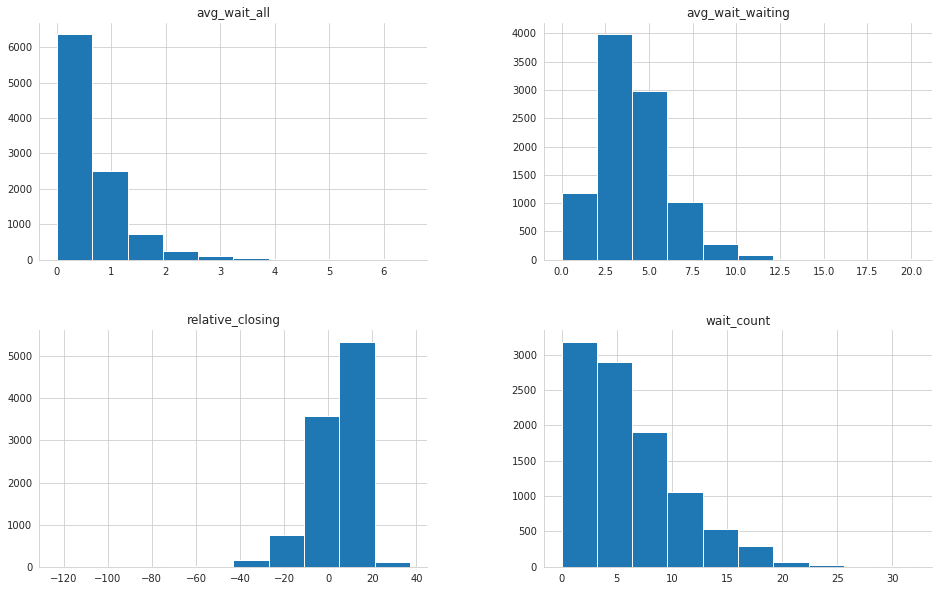

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
resultFrame.hist(figsize=(16,10))
sns.despine()
plt.show()